In [1]:
import numpy as np
from mask_utils import *
from scipy.signal import convolve
import matplotlib.pyplot as plt
import matplotlib_inline
from scipy.signal import correlate
from matplotlib import cm
from astropy.table import Table, Column
from scipy.optimize import curve_fit

In [2]:
def read_events(filein, header0=False, header1=False):
    with pyfits.open(filein) as hdu_list:
        header_0 = hdu_list[0].header
        header_1 = hdu_list[1].header
        hdu_list.info()
        data = hdu_list[1].data
        events = Table(data)

        if not header0 and not header1:
            return events
        elif header0 and not header1:
            return events, header_0
        elif not header0 and header1:
            return events, header_1
        elif header0 and header1:
            return events, header_0, header_1

In [3]:
def _modsech(x,norm,center,alpha,beta):
    """
    PSF fitting function template.

    Args:
        x: a numpy array or value, in millimeters
        norm: normalization parameter
        center: center parameter
        alpha: alpha shape parameter
        beta: beta shape parameter

    Returns:
        numpy array or value, depending on the input
    """
    return norm / np.cosh(np.abs((x - center) / alpha) ** beta)
def norm_modsech(x,center,alpha,beta):
    return _modsech(x,1,center,alpha,beta)
    
def psfy_wfm(x):
    return _modsech(x, norm=1, **_PSFY_WFM_PARAMS)

def psfy_wfm_peppe(x):
    return _modsech(x, norm=1, **_PSFY_WFM_PARAMS_PEPPE)


In [4]:
_PSFY_WFM_PARAMS = {
    "center": 0,
    "alpha": 0.3214,
    "beta": 0.6246,
}  

#Peppe's version

_PSFY_WFM_PARAMS_PEPPE = {
    "center": 0,
    "alpha": 0.2592319088817486,
    "beta":0.5972963324935765,
}

In [5]:
fdet = "catalog_noCXB_1Crab_infthinmask_2-50keV_1ks_cam1a_detected.fits"
frec = "catalog_noCXB_1Crab_infthinmask_2-50keV_1ks_cam1a_reconstructed.fits"

In [32]:
det, hdet0, hdet1 = read_events(fdet, header0=True, header1=True)
rec, hrec0, hrec1 = read_events(frec, header0=True, header1=True)

Filename: catalog_noCXB_1Crab_infthinmask_2-50keV_1ks_cam1a_detected.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  EVENTS        1 BinTableHDU     38   531402R x 11C   [K, D, D, D, D, D, D, D, D, D, D]   
Filename: catalog_noCXB_1Crab_infthinmask_2-50keV_1ks_cam1a_reconstructed.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  RECONSTRUCTED    1 BinTableHDU    101   529007R x 33C   [K, K, K, K, D, D, D, D, D, D, D, D, I, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [33]:
pntra = hdet0['INSTZRA']
pntdec = hdet0['INSTZDEC']
print(pntra, pntdec)


266.4 -28.94


In [34]:
rec_sorted_id = rec[rec["ID"].argsort()]
det_sorted_id = det[det["ID"].argsort()]

u, c = np.unique(rec["ID"], return_counts=True)
rec_unique_ids = u[c == 1]

det_ids = np.unique(det["ID"])
selected_ids = np.intersect1d(rec_unique_ids, det_ids)

rec_sorted_unique = rec_sorted_id[np.isin(rec_sorted_id["ID"], selected_ids)]
det_sorted_unique = det_sorted_id[np.isin(det_sorted_id["ID"], selected_ids)]

x_det = np.array([])
x_rec = np.array([])

y_det = np.array([])
y_rec = np.array([])

x_det = np.concatenate((x_det, det_sorted_unique["X"]))
x_rec = np.concatenate((x_rec, rec_sorted_unique["X"]))

y_det = np.concatenate((y_det, det_sorted_unique["Y"]))
y_rec = np.concatenate((y_rec, rec_sorted_unique["Y"]))


In [35]:
#Fitering by source RA, DEC
mask = np.ones(len(rec_sorted_unique), dtype=bool)
mask &= (np.isclose(rec_sorted_unique["RA"], pntra) & np.isclose(rec_sorted_unique["DEC"], pntdec))

x_det = x_det[mask]
x_rec = x_rec[mask]


y_det = y_det[mask]
y_rec = y_rec[mask]
print("Found ", np.sum(mask), "out of ", len(mask), "photons")

Found  97817 out of  528987 photons


In [36]:
diff = y_det - y_rec

In [11]:
bins = np.linspace(-25, 25, 1001)
h, _ = np.histogram(diff, bins=bins, density=True)

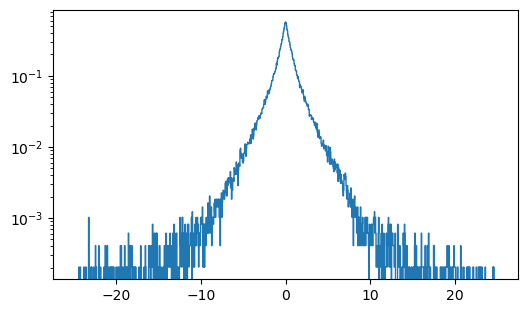

In [12]:
plt.figure(figsize=(6, 3.5))
plt.stairs(h, edges=bins)
plt.yscale('log')
plt.show()

In [16]:
midpoints = (bins[1:] + bins[:-1]) / 2
psfy = psfy_wfm(midpoints)
psfy = psfy/np.sum(psfy) * np.sum(h)

psfy_p = psfy_wfm_peppe(midpoints)
psfy_p = psfy_p/np.sum(psfy_p) * np.sum(h)

In [17]:
res, pcov = curve_fit(f=_modsech, xdata = midpoints, ydata=h, p0=(0, 1.0, 0.32, 0.64))
print(f"best fit parameters: alpha={res[2]}, beta={res[3]}")

best fit parameters: alpha=0.2804246034173188, beta=0.5595738441185949


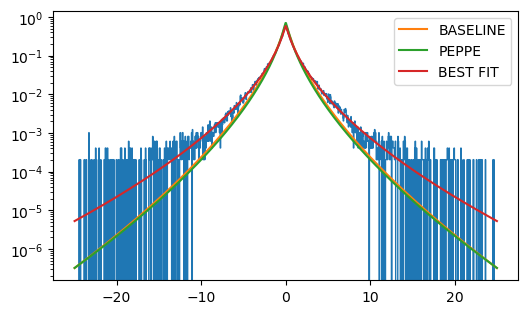

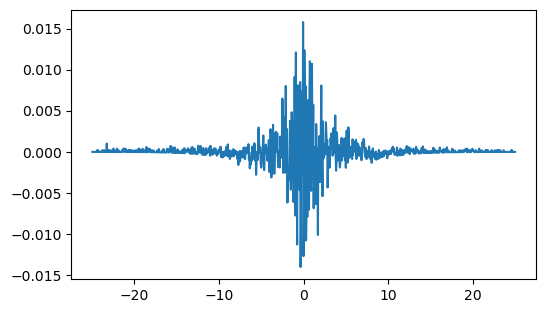

In [18]:
plt.figure(figsize=(6, 3.5))
plt.stairs(h, edges=bins)
plt.plot(midpoints, psfy, label="BASELINE")
plt.plot(midpoints, psfy_p, label = "PEPPE")
plt.plot(midpoints, _modsech(midpoints, *res), label="BEST FIT")
plt.legend()
plt.yscale('log')

plt.figure(figsize=(6, 3.5))
plt.plot(midpoints, h - _modsech(midpoints, *res))
#plt.yscale('log')
plt.show()

In [21]:
rmatrix, hdmask = read_mask_bulk('wfm_mask.fits', 3, header_out=True)
bulk = read_mask_bulk('wfm_mask.fits', 4)

Filename: wfm_mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   ()      
  1  OR_MASK       1 BinTableHDU     36   676000R x 3C   [E, E, E]   
  2  MASK          1 BinTableHDU     36   676000R x 3C   [E, E, E]   
  3  RMATRIX       1 BinTableHDU     38   676000R x 3C   [E, E, E]   
  4  SENS          1 BinTableHDU     36   676000R x 3C   [E, E, E]   
Filename: wfm_mask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   ()      
  1  OR_MASK       1 BinTableHDU     36   676000R x 3C   [E, E, E]   
  2  MASK          1 BinTableHDU     36   676000R x 3C   [E, E, E]   
  3  RMATRIX       1 BinTableHDU     38   676000R x 3C   [E, E, E]   
  4  SENS          1 BinTableHDU     36   676000R x 3C   [E, E, E]   


In [27]:
ELXDIM = hdmask['ELXDIM']
ELYDIM = hdmask['ELYDIM']
ELXN   = hdmask['ELXN']
ELYN   = hdmask['ELYN']

#Generate pixel coords (centers) in mask reference frame
xcoords = np.arange(0, ELXDIM * ELXN, ELXDIM) + ELXDIM/2 - (ELXDIM * ELXN)/2
ycoords = np.arange(0, ELYDIM * ELYN, ELYDIM) + ELYDIM/2 - (ELYDIM * ELYN)/2

In [86]:

xedges = xcoords-ELXDIM/2
xedges = np.append(xedges, xcoords[-1] + ELXDIM/2)

yedges = ycoords-ELYDIM/2
yedges = np.append(yedges, ycoords[-1] + ELYDIM/2)
 
detimage_det, _, _ = np.histogram2d( x_det, y_det, bins=(xedges, yedges) )
detimage_rec, _, _ = np.histogram2d( x_rec, y_rec, bins=(xedges, yedges) )


cc_det = correlate(rmatrix, detimage_det, mode="full")
cc_rec = correlate(rmatrix, detimage_rec, mode="full")

balancing = correlate(rmatrix, bulk, mode="full")

cc_bal_det = cc_det - balancing * np.sum(detimage_det) / np.sum(bulk)
cc_bal_rec = cc_rec - balancing * np.sum(detimage_rec) / np.sum(bulk)



In [87]:
pmax = np.unravel_index(np.argmax(cc_bal), cc_bal_det.shape)
print(pmax)

(1039, 649)


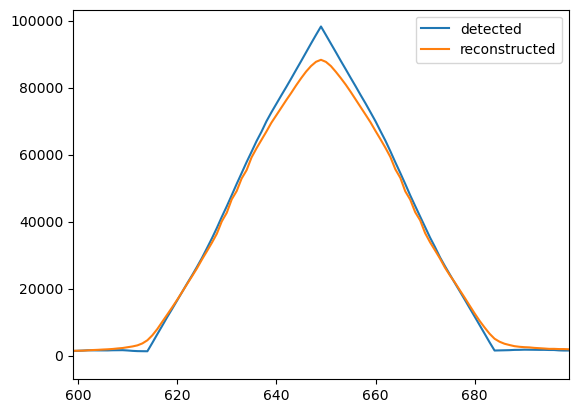

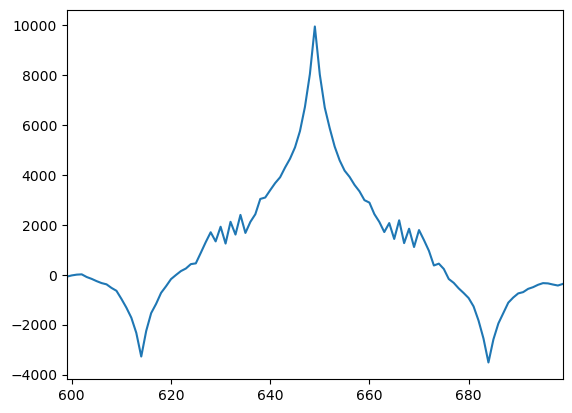

In [88]:
#plt.figure(figsize=(10, 6))
plt.plot(cc_bal_det[pmax[0], : ], label='detected')
plt.plot(cc_bal_rec[pmax[0], : ], label='reconstructed')
plt.xlim(pmax[1]-50, pmax[1]+50)
plt.legend()
plt.show()

plt.plot(cc_bal_det[pmax[0], : ] - cc_bal_rec[pmax[0], : ])
plt.xlim(pmax[1]-50, pmax[1]+50)
plt.show()

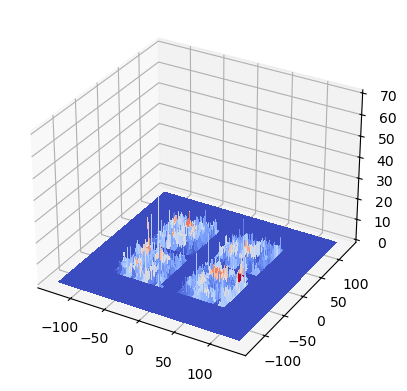

In [89]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X, Y = np.meshgrid(xcoords, ycoords)

surf = ax.plot_surface(X, Y, detimage_rec.T, cmap=cm.coolwarm, linewidth=0, antialiased=False)

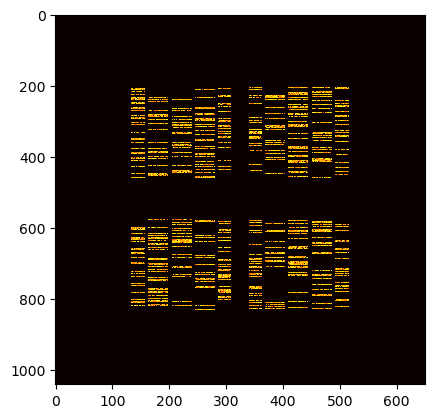

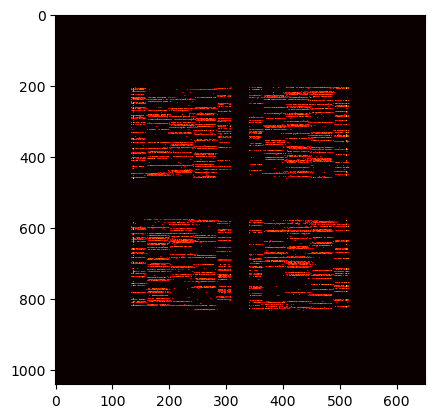

In [90]:
plt.imshow(detimage_det**0.25, cmap=cm.hot,  interpolation='nearest', aspect=ELXDIM/ELYDIM)
plt.show()
plt.imshow(detimage_rec**0.25, cmap=cm.hot,  interpolation='nearest', aspect=ELXDIM/ELYDIM)

plt.show()

In [95]:
#I try to "erode" the bulk in order to elimiate the artifacts
cut = 2
step = 1
bulk_small = erosion(bulk, cut, step)
bulk_small = erosion(bulk_small, -1 * cut, step)


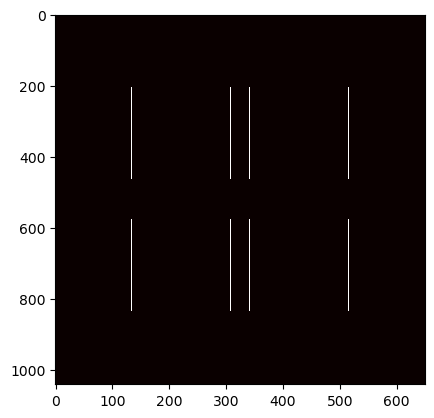

In [96]:
plt.imshow(bulk - bulk_small, cmap=cm.hot,  interpolation='nearest', aspect=ELXDIM/ELYDIM)


In [97]:

detimage_rec_e = detimage_rec * bulk_small

cc_rec_e = correlate(rmatrix, detimage_rec_e, mode="full")

balancing_e = correlate(rmatrix, bulk_small, mode="full")

cc_bal_rec_e = cc_rec_e - balancing_e * np.sum(detimage_rec_e) / np.sum(bulk_small)

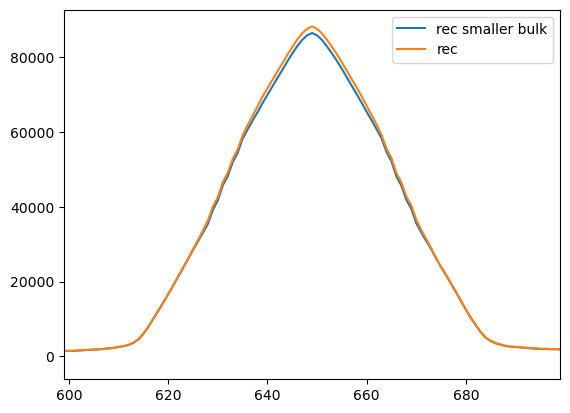

In [98]:
#plt.figure(figsize=(10, 6))
plt.plot(cc_bal_rec_e[pmax[0], : ], label='rec smaller bulk')
plt.plot(cc_bal_rec[pmax[0], : ], label='rec')

plt.xlim(pmax[1]-50, pmax[1]+50)
plt.legend()
plt.show()

